In [1]:
%reload_ext autoreload
%autoreload 2
import itertools

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
# load data
var1_head = ['team%d_pick%d' % (i,j) for i in range(2) for j in range(1, 6)]
var2_head = ['team%d_ban%d' % (i,j) for i in range(2) for j in range(1, 6)]
var_head = var1_head + var2_head
head = var_head + ['label']
file = 'out.csv'
df = pd.read_csv(file, header=None, names=head, dtype='Int64')
df.dropna(inplace=True)
print(df.shape)

(41600, 21)


In [3]:
# get 2-hero combination counts
hash_dict = dict()
def get_2combine(data, suffix='_0', hash_dict=None):
    res = dict()
    for i, x in enumerate(itertools.combinations(data.to_list(), 2)):
        h_value = hash(str(x))
        if h_value not in hash_dict:
            hash_dict[h_value] = x
        res['hash_%d_%s' % (i, suffix)] = h_value
    return res
team0_combine = pd.DataFrame(df[['team0_pick%d' % i for i in range(1, 6)]].apply(get_2combine, axis=1, hash_dict=hash_dict).to_list())
team1_combine = pd.DataFrame(df[['team1_pick%d' % i for i in range(1, 6)]].apply(get_2combine, axis=1, hash_dict=hash_dict).to_list())
combine = pd.concat([team0_combine, team1_combine])
combine_count = pd.value_counts(combine.values.ravel('K')).sort_values(ascending=False)
combine_list = [hash_dict[x] for x in combine_count.head(50).index.tolist()]
print(combine_count.head(50))
print(combine_list)

-3932487295444721162    658
-1629355414208796232    633
 1837640841132248657    603
 4483455966727560384    576
-8857147942379365901    528
-5449412891858597149    526
-2888136126061415634    478
 8238961693470919183    467
-6211399015075872247    465
-550400701356332127     447
-8331027120910908059    442
 6246847689134507972    438
-4099578331416154517    433
-201445503289127466     432
 4097797503751164160    423
-8700968755916752120    418
 4181280514129052296    415
-6956584331406344703    412
 2953643572249850699    408
-487312675303835566     408
-4524359626171580268    401
 586895712464583214     401
-6564504220430150613    401
-4308619034658160756    400
 8611400613156933298    397
-8904896754239018901    389
-6738021983078693952    385
 4266116684044690404    382
 21995076517645171      380
-386837284360898520     379
 181481553967377977     376
 3453129040883064786    376
-5778900890445670120    375
 8967201729793603507    375
-8134009483080656107    373
 4797013606225075669

In [4]:
heros = pd.unique(df[var_head].values.ravel('K'))
heros.sort()
print(len(heros))
str_heros = [str(hero) for hero in heros]
print(','.join(str_heros))

df_t = []
for row in df[var_head].itertuples(index=False):
    temp = []
    for h in heros:
        if h in row[:5]:
            temp.append(1)
        elif h in row[5: 10]:
            temp.append(-1)
        else:
            temp.append(0)
    df_t.append(temp)

df_t = pd.DataFrame(df_t, columns=heros)

for h1, h2 in combine_list:
    df_t['%d_%d_team0' % (h1, h2)] = ((df_t[h1] + df_t[h2]) == 2).astype(int)
    df_t['%d_%d_team1' % (h1, h2)] = ((df_t[h1] + df_t[h2]) == -2).astype(int)

119
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,119,120,121,126,128,129


In [5]:
print(df_t.head())
print(df_t.shape)
X_train, X_test, y_train, y_test = train_test_split(df_t, df['label'].astype(int), test_size=0.2, random_state=42)

   1  2  3  4  5  6  7  8  9  10  ...  86_23_team0  86_23_team1  39_7_team0  \
0  0  0  0  0  0 -1  0  0  0   0  ...            0            0           0   
1  0  0  0  0  0  0  0  0  0   0  ...            0            0           0   
2  0  0  0  0  0  0  0  0  0   0  ...            0            0           0   
3  0  0  0  0  0 -1  0  0 -1   0  ...            0            0           0   
4  0  0  0  0  0  0  0 -1  0   0  ...            0            0           0   

   39_7_team1  100_39_team0  100_39_team1  16_8_team0  16_8_team1  \
0           0             0             0           0           0   
1           0             0             0           0           0   
2           0             0             0           0           0   
3           0             0             0           0           0   
4           0             0             0           0           0   

   55_87_team0  55_87_team1  
0            0            0  
1            0            0  
2            0      

0.5647235576923076
0.5498798076923077
(8320, 219)
[[2641 1663]
 [2082 1934]]


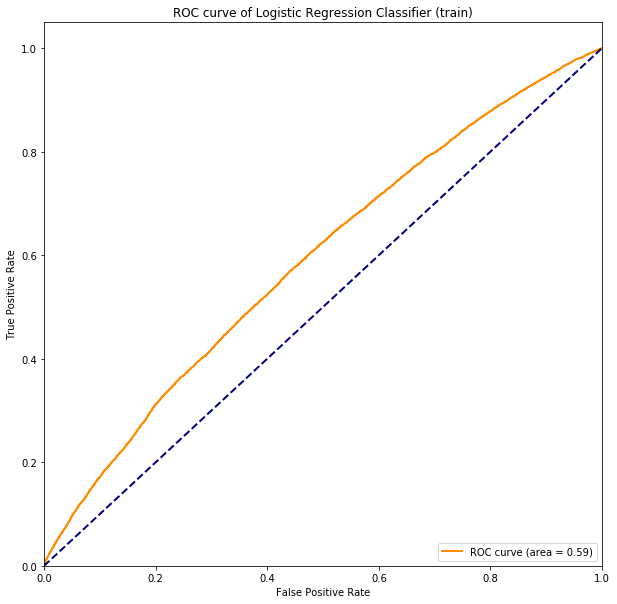

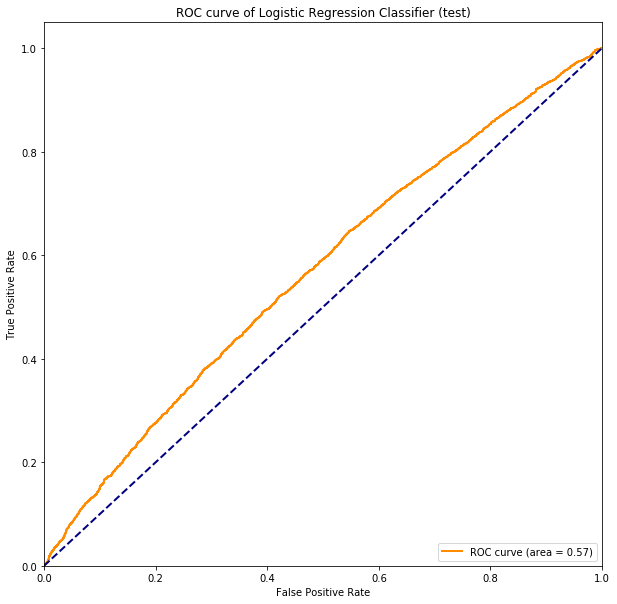

In [11]:
def get_metrics(model, data):
    X_test, y_test = data
    # get confusion matrix
    print(X_test.shape)
    y_pred = model.predict(X_test)
    c_mat = confusion_matrix(y_test, y_pred)
    print(c_mat)


def draw_roc_auc(model, data, model_name):
    X_test, y_test = data
    y_score = model.predict_proba(X_test)
    fpr, tpr, threshold=roc_curve(y_test, y_score[:, 1])
    
    roc_auc=auc(fpr,tpr)
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
    lw=2, label='ROC curve (area = %0.2f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve of {}'.format(model_name))
    plt.legend(loc="lower right")
    plt.savefig(model_name)
    plt.show()

# logistic regression
lr = LogisticRegression(random_state=0).fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

get_metrics(lr, (X_test, y_test))
draw_roc_auc(lr, (X_train, y_train), 'Logistic Regression Classifier (train)')
draw_roc_auc(lr, (X_test, y_test), 'Logistic Regression Classifier (test)')

In [6]:
# Decision Tree
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
decision_tree_clf = DecisionTreeClassifier(random_state=0, max_depth=8)
decision_tree_clf.fit(X_train, y_train)
#score = cross_val_score(decision_tree_clf, X_train, y_train, cv=10)
#print(score)

DecisionTreeClassifier(max_depth=8, random_state=0)

In [7]:
from sklearn.svm import SVC
svm_clf = SVC(C=1.0, kernel='rbf', gamma='auto')
svm_clf.fit(X_train, y_train)
#score = cross_val_score(svm_clf, X_train, y_train, cv=10)
#print(score)

In [27]:
import model_fusion

fused_model, acc = model_fusion.model_fusion(decision_tree_clf, lr, lr, X_train, y_train)

TypeError: 'float' object cannot be interpreted as an integer